In [1]:
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pprint import pprint

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split


In [2]:
img_dir = '/opt/ml/input/data/train/images'

In [3]:
transform = Compose([
    transforms.CenterCrop((380,380)),
    
    ###############Augmentation methods##################
    # transform.RandomHorizontalFlip(p=0.5)
    transforms.ToTensor()
    
])

In [4]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None) -> None:
        super().__init__()

        self.transform = transform
        self.path_list = []
        self.mask_list = []
        self.gender_list = []
        self.age_list = []
        
        
        ## image dir
        profiles = os.listdir(img_dir)
        for dir in profiles:
            if dir[0]=='.':
                continue
            
            dir_path = os.path.join(img_dir, dir)
            for file_name in os.listdir(dir_path):
                if file_name[0]=='.':
                    continue
                name, _ = os.path.splitext(file_name)
                
                ## mask label
                if name in ['mask1','mask2','mask3','mask4','mask5']:
                    mask = 0
                elif name == 'incorrect_mask':      ## incorrect
                    mask = 1 
                else:                               ## normal
                    mask = 2 

                ## label info <- diretory name
                _, gender, race, age = dir.split('_')
                
                ## gender label
                gender_dict = {'male':0, 'female':1}
                gender_val = gender_dict[gender]
                
                age = int(age)
                ## age label
                if age >= 60:
                    age_val = 2
                elif age >= 30:
                    age_val = 1 
                else:
                    age_val = 0
                
                self.path_list.append(os.path.join(img_dir, dir, file_name))
                self.mask_list.append(mask)
                self.gender_list.append(gender_val)
                self.age_list.append(age_val)
        

    def __getitem__(self, index):
        
        image = Image.open(self.path_list[index])
                
        if self.transform:
            image = self.transform(image)
        
        # image = image.permute(1,2,0)
        image = np.array(image)
        category = self.mask_list[index]*6 + self.gender_list[index]*3 + self.age_list[index]
        return image, category
            
        # return image, self.mask_list[index], self.gender_list[index],self.age_list[index]
        
    def __len__(self):
        return len(self.path_list)

In [6]:
# length = len(dataset)
# ## train,test split
# trainset, validset = random_split(transformed_dataset, [int(length*0.8), int(length*0.2)])

In [5]:
train_dataset = CustomDataset(
    img_dir,
    transform
)

val_dataset = CustomDataset(
    img_dir,
    transform
)

# train dataset과 validation dataset을 8:2 비율로 나눕니다.

train_indices, val_indices = train_test_split([i for i in range(len(train_dataset))],test_size=0.2)

# 각 dataset에 augmentation 함수를 설정합니다.

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

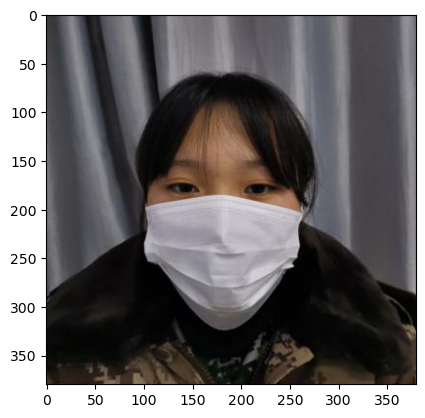

In [6]:
plt.imshow(torch.Tensor(next(iter(val_dataset))[0]).permute(1,2,0))

In [52]:
next(iter(train_dataset))

(array([[[0.83137256, 0.83137256, 0.83137256, ..., 0.8392157 ,
          0.8392157 , 0.8392157 ],
         [0.83137256, 0.83137256, 0.83137256, ..., 0.8392157 ,
          0.8392157 , 0.8392157 ],
         [0.83137256, 0.83137256, 0.83137256, ..., 0.8392157 ,
          0.8392157 , 0.8392157 ],
         ...,
         [0.17254902, 0.1764706 , 0.1764706 , ..., 0.20784314,
          0.19607843, 0.1882353 ],
         [0.18039216, 0.18039216, 0.1764706 , ..., 0.21176471,
          0.2       , 0.19607843],
         [0.18431373, 0.18431373, 0.1764706 , ..., 0.21568628,
          0.20392157, 0.19607843]],
 
        [[0.7921569 , 0.7921569 , 0.7921569 , ..., 0.8       ,
          0.8       , 0.8       ],
         [0.7921569 , 0.7921569 , 0.7921569 , ..., 0.8       ,
          0.8       , 0.8       ],
         [0.7921569 , 0.7921569 , 0.7921569 , ..., 0.8       ,
          0.8       , 0.8       ],
         ...,
         [0.17254902, 0.1764706 , 0.1764706 , ..., 0.21568628,
          0.20392157, 0.

In [7]:
## train, valid loader
train_loader = DataLoader(train_dataset, batch_size = 32, num_workers =4, shuffle= True)
valid_loader = DataLoader(val_dataset, batch_size = 32, num_workers =4, shuffle= False)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [9]:
from torchvision.models import efficientnet_b4
import torch

In [10]:
## B4 input : 380x380
model= efficientnet_b4(pretrained=True)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model.classifier[1]= nn.Linear(1792,18)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [13]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_val_score = 0
    best_model = None
    
    for epoch in range(1, 101):
        model.train()
        train_loss = []
        for images, labels in tqdm(iter(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # print(images.shape)
            output = model(images)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
            print('model saved epoch {}'.format(epoch))
            torch.save(best_model.state_dict(), '/opt/ml/weights/baseline_effib4_{}epochs.pt'.format(epoch))
    
    return best_model

In [14]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(iter(val_loader)):
            images = images.to(device)
            labels = labels.to(device)
            
            logit = model(images)
            
            loss = criterion(logit, labels)
            
            val_loss.append(loss.item())
            

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()
        
        _val_loss = np.mean(val_loss)
    
    _val_score = f1_score(trues, preds, average='macro')

    # _val_score = accuracy_score(trues, preds)
    return _val_loss, _val_score

In [15]:
from tqdm import tqdm

In [16]:
# model.load_state_dict(torch.load('PATH'))

optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, valid_loader, scheduler, device)

100%|██████████| 119/119 [00:14<00:00,  8.29it/s]


Epoch [1], Train Loss : [0.58748] Val Loss : [0.16202] Val F1 : [0.84605]
model saved epoch 1


100%|██████████| 119/119 [00:14<00:00,  8.37it/s]


Epoch [2], Train Loss : [0.14051] Val Loss : [0.06595] Val F1 : [0.94352]
model saved epoch 2


 16%|█▋        | 78/473 [00:33<02:50,  2.32it/s]


KeyboardInterrupt: 

In [35]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform=None) -> None:
        super().__init__()
        self.img_paths = img_paths
        self.transform = transform
        
    def __getitem__(self, index):
        
        image = Image.open(self.img_paths[index])
                
        if self.transform:
            image = self.transform(image)
        
        image = np.array(image)
        return image
                    
    def __len__(self):
        return len(self.img_paths)

In [36]:


import pandas as pd
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# device = torch.device('cuda')
# model = MyModel(num_classes=18).to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
